### Imports & Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, precision_score

### Data processing

In [2]:
data1 = pd.read_csv('./Data/24h-chopinessIndex.csv')
data2 = pd.read_csv('./Data/cci-macross.csv')
data3 = pd.read_csv('./Data/massindex-relativeVol.csv')
data4 = pd.read_csv('./Data/rob-vortex.csv')
data5 = pd.read_csv('./Data/last.csv')
data7 = pd.read_csv('./Data/ICEUS.csv')
data8 = pd.read_csv('./Data/DXY.csv')
data9 = pd.read_csv('./Data/SP_SPN.csv')
data10 = pd.read_csv('./Data/SP_SPX.csv')
data11 = pd.read_csv('./Data/GOLD.csv')
data12 = pd.read_csv('./Data/US10Y.csv')
data13 = pd.read_csv('./Data/USOIL.csv')
data14 = pd.read_csv('./Data/VIX.csv')

data = [data1, data2, data3, data4, data5, data7, data8, data9, data10, data11, data12, data13, data14]

In [3]:
for i in range(len(data)):
    data[i].set_index('time', drop=True, inplace=True)
    data[i].index = data[i].index.str.slice(0, 10)

In [4]:
# Renaming merged columns
df = (
    data1
    .join(data2, rsuffix='_2')
    .join(data3, rsuffix='_3')
    .join(data4, rsuffix='_4')
    .join(data5, rsuffix='_5')
)

# Drop last line for Close d+1 nan
df = df.drop(df.index[len(df)-1])

# Drop cols with >= 100 nan cols
nan100_columns = df.columns[df.isna().sum() >= 100]
df[nan100_columns].isnull().sum()
df.drop(columns=nan100_columns, inplace=True)

# Inputting nan's
df.fillna(method='bfill', inplace=True)

In [5]:
# Renaming merged columns
df = (
    df
    .join(data7, rsuffix='_ICEUS')
    .join(data8, rsuffix='_DXY')
    .join(data9, rsuffix='_SP_SPN')
    .join(data10, rsuffix='_SP_SPX')
    .join(data11, rsuffix='_GOLD')
    .join(data12, rsuffix='_US10Y')
    .join(data13, rsuffix='_USOIL')
    .join(data14, rsuffix='_VIX')
)

# Drop last line for Close d+1 nan
df = df.drop(df.index[len(df)-1])
df = df.fillna(method='ffill')

# Drop cols with >= 100 nan cols
nan100_columns = df.columns[df.isna().sum() >= 100]
df[nan100_columns].isnull().sum()
df.drop(columns=nan100_columns, inplace=True)

In [6]:
# Removing duplicate cols
drop_cols = []
colunas_verificadas = set()
for col1 in df.columns:
    if col1 not in colunas_verificadas:
        for col2 in df.columns:
            if col1 != col2 and (df[col1] == df[col2]).all():
                drop_cols.append(col2)
                colunas_verificadas.add(col2)

df=(df.drop(columns=drop_cols).
    fillna(method='bfill').
    fillna(method='ffill'))

In [7]:
# Filtering period
df.index = df.index.str.slice(0, 10)
df = df[df.index >= '2012-01-01']

In [8]:
# Dropping low feature importance variables (previously calculated)
drop_cols = ['close_USOIL','Plot.5_2','Signal.1_4','True Strength Index','KST','open_USOIL','MOM','open_VIX','open_US10Y','high_DXY','low_GOLD','Elder Force Index','TRIX','high_SP_SPN','high_US10Y','BBPower','EOM','high_VIX','close_SP_SPN','Signal','close_US10Y','close_GOLD','Detrended Price Oscillator','open_DXY','high_GOLD','MACD','high_USOIL','Histogram','low_USOIL','low_VIX','low_SP_SPN','OnBalanceVolume','Lagging Span','Plot.6','low_US10Y','ADR','Accumulation/Distribution','Signal_3','open_GOLD','Plot.6_2','ATR','Smoothing Line.2','high_SP_SPX','low_SP_SPX','Leading Span A','MA №3','Aroon Down','Lower','close_SP_SPX','open_SP_SPX','Lower_2','Kumo Cloud Upper Line','Advance Decline Line','Upper_2','Aroon Up','ParabolicSAR','Plot_3','Upper Band','Lower Band','MA №2','Upper Band #3','Median EMA','Chars','Kumo Cloud Lower Line','Jaw','Leading Span B','ADR_B','Upper Band #2','Lower Band #2','TEMA','Plot.4_2','Plot.1_4','DEMA','Plot_4','Basis_2','WMA','Upper','Volatility Stop','Lower Band #1','Plot.3_2','Upper Band #1','Plot_2','Teeth','Chars.1','Plot.1_2','VWAP','Conversion Line','Plot','Lips','Median','Plot.4','TWAP','Lower.2','Basis','Smoothing Line.1','Chars.2','Lower Band #3','Basis.3','Base Line','VWMA','Lower.3','Smoothing Line_3','Upper.2','EMA','Plot.1','Chars.3','Upper.3','Plot.2_3','Plot.3_4','Plot.8']
df.drop(columns=drop_cols, inplace=True)

### Preparing dataframe

In [47]:
# Data selection
data = df.copy()

# Adding return
data['return'] = data['close'].pct_change()

# Adding past returns
for i in range(1,6):
    data[f'return d-{i}'] = data['return'].shift(i)

# Adding future returns
data['return d+1'] = data['return'].shift(-1)

# Adding target (price[i+10] >= price[i])
data['Sign'] = (data['close'].shift(-1) >= data['close']).apply(lambda x: 1 if x else -1)
data = data.iloc[:-10]

# Dropping first 6 lines and last line (due to nan's)
data = data.iloc[6:-1]

# Dropping open, high, low, close
data_res = data[['open', 'high', 'low', 'close', 'return d+1']]
data.drop(columns=['open', 'high', 'low', 'close', 'return d+1'], inplace=True)

# Get columns
cols = data.columns

# Splitting data
df_past = data.loc[ data.index < '2019-01-01'].sort_index()
df_future = data.loc[ (data.index >= '2019-01-01') & (data.index < '2023-01-01')].sort_index()

# Train-Test setting
X_train = df_past[cols[:-1]]
y_train = df_past[cols[-1]]

X_test = df_future[cols[:-1]]
y_test = df_future[cols[-1]]

# Exporting X and y to be used on tunning phase
X_train.to_csv('X_past.csv')
y_train.to_csv('y_past.csv')

In [43]:
# Training model
model = RandomForestClassifier( bootstrap = True,
                                class_weight= "balanced",
                                n_estimators = 1200,
                                min_samples_split = 2,
                                min_samples_leaf = 4,
                                max_features = 'auto',
                                max_depth = 30,
                                random_state = 0)
model.fit(X_train, y_train)

c:\Users\Homeoffice\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(class_weight='balanced', max_depth=30,
                       max_features='auto', min_samples_leaf=4,
                       n_estimators=1200, random_state=0)

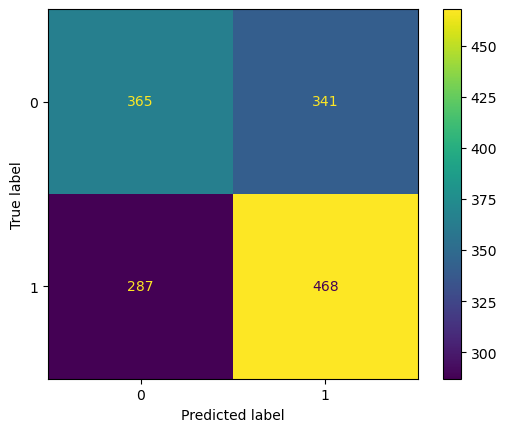

f1_score:  0.5984654731457801
recall_score:  0.6198675496688741
precision_score:  0.5784919653893696


In [49]:
# Testing model
preds = model.predict(X_test)

cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print('f1_score: ', f1_score(y_test, preds))
print('recall_score: ', recall_score(y_test, preds))
print('precision_score: ', precision_score(y_test, preds))

In [104]:
# Creating results dataframe
results = pd.DataFrame({
    "pred_sign": preds,
    "prob_sign_is_1": model.predict_proba(X_test)[:,1],
    "true_sign": y_test,
    "return_d": X_test['return'],
    "return_d+1": data_res['return d+1'].loc[ (data.index >= '2019-01-01') & (data.index < '2023-01-01') ].iloc[:-1],    
    "close_d": data_res['close'].loc[ (data.index >= '2019-01-01') & (data.index < '2023-01-01') ].iloc[:-1],
    "close_d+1": data_res['close'].loc[ (data.index >= '2019-01-01') & (data.index < '2023-01-01') ].iloc[:-1].shift(-1)
    #"d+1_true": data_res['close'].loc[ (data.index >= '2019-01-01') & (data.index < '2023-01-01') ].iloc[:-1].shift(-1),
    #"high": data_res['high'].loc[ (data.index >= '2019-01-01') & (data.index < '2023-01-01') ].iloc[:-1].shift(1),
    #"low": data_res['low'].loc[ (data.index >= '2019-01-01') & (data.index < '2023-01-01') ].iloc[:-1].shift(1)
})
results

,pred_sign,prob_sign_is_1,true_sign,return_d,return_d+1,close_d,close_d+1
time,,,,,,,
2019-01-01,1,0.519743,1,0.035237,0.016328,3823.44,3885.87
2019-01-02,-1,0.272794,-1,0.016328,-0.025235,3885.87,3787.81
2019-01-03,-1,0.468451,1,-0.025235,0.007894,3787.81,3817.71
2019-01-04,1,0.602226,-1,0.007894,-0.006776,3817.71,3791.84
2019-01-05,-1,0.473883,1,-0.006776,0.065633,3791.84,4040.71
...,...,...,...,...,...,...,...
2022-12-27,-1,0.468253,-1,-0.012827,-0.009581,16700.00,16540.00
2022-12-28,-1,0.498983,1,-0.009581,0.005320,16540.00,16628.00
2022-12-29,1,0.525450,-1,0.005320,-0.001503,16628.00,16603.00


In [14]:
# Getting feature importances to drop less relevant feats
for feat, importance in zip(df_past.columns[:-1], model.feature_importances_):
    pass

feat_importance = pd.DataFrame({'feat':df_past.columns[:-1],  'importance':model.feature_importances_})
feat_importance.sort_values('importance', ascending=False, inplace=True)

In [68]:
# Exporting results
results.reset_index().to_csv('output_rf_final.csv')